<a href="https://colab.research.google.com/github/HelloShagun/CEMS_download/blob/main/CEMS_GFM_contingency_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!pip install rasterio

## For One Flood Product

In [16]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.patches as mpatches


# =====================================================
# Utility: visualize raster
# =====================================================
def show_raster(raster_path, title="Raster Preview", cmap='viridis'):
    with rasterio.open(raster_path) as src:
        data = src.read(1, masked=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap=cmap)
    plt.title(title)
    plt.colorbar(label="Pixel values")
    plt.axis("off")
    plt.show()


# =====================================================
# Step 0 — Align and reproject any raster to a reference
# =====================================================
def align_raster_to_reference(input_raster, reference_raster, out_path):
    with rasterio.open(input_raster) as src, rasterio.open(reference_raster) as ref:
        if src.crs != ref.crs or src.transform != ref.transform or src.shape != ref.shape:
            print("⚙️ Aligning and reprojecting exclusion mask to match reference raster...")
            transform, width, height = calculate_default_transform(
                src.crs, ref.crs, ref.width, ref.height, *ref.bounds
            )

            kwargs = ref.meta.copy()
            kwargs.update({
                'transform': ref.transform,
                'width': ref.width,
                'height': ref.height,
                'crs': ref.crs
            })

            data = np.zeros((ref.count, ref.height, ref.width), dtype=src.read(1).dtype)
            reproject(
                source=rasterio.band(src, 1),
                destination=data[0],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                resampling=Resampling.nearest
            )

            with rasterio.open(out_path, 'w', **kwargs) as dst:
                dst.write(data)
        else:
            print("✅ Raster already aligned with reference.")
            data = src.read(1)
            kwargs = src.meta
            with rasterio.open(out_path, 'w', **kwargs) as dst:
                dst.write(data, 1)

    return out_path


# =====================================================
# Step 1 — Clip raster to AOI
# =====================================================
def clip_raster_to_aoi(raster_path, shapefile_path, out_path, show=True):
    gdf = gpd.read_file(shapefile_path)
    with rasterio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(out_path, "w", **out_meta) as dst:
            dst.write(out_image)

    if show:
        show_raster(out_path, "Raster1 - Clipped AOI")
    return out_path


# =====================================================
# Step 2 — Rasterize shapefile2 to match raster1
# =====================================================
def rasterize_vector_like(vector_path, reference_raster, out_path, burn_value=1, show=True):
    gdf = gpd.read_file(vector_path)
    with rasterio.open(reference_raster) as ref:
        transform, out_shape, crs, dtype, nodata = ref.transform, (ref.height, ref.width), ref.crs, ref.dtypes[0], ref.nodata
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)
    shapes = ((geom, burn_value) for geom in gdf.geometry)
    raster = rasterize(shapes, out_shape=out_shape, transform=transform, fill=0, dtype=dtype)
    meta = {"driver": "GTiff", "height": raster.shape[0], "width": raster.shape[1],
            "count": 1, "dtype": dtype, "crs": crs, "transform": transform, "nodata": nodata}
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(raster, 1)
    if show:
        show_raster(out_path, "Raster2 - Rasterized shapefile2")
    return out_path


# =====================================================
# Step 3 — Apply exclusion layer (masked out)
# =====================================================
def apply_exclusion_layer(target_raster, exclusion_raster, out_path, show=True):
    with rasterio.open(target_raster) as target, rasterio.open(exclusion_raster) as excl:
        target_data = target.read(1)
        excl_data = excl.read(1)
        target_data[excl_data == 1] = target.nodata if target.nodata is not None else 0
        meta = target.meta
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(target_data, 1)
    if show:
        show_raster(out_path, "Raster with Exclusion Applied")
    return out_path


# =====================================================
# Step 4 — Compare rasters inside AOI with exclusion
# =====================================================
def compare_rasters_inside_aoi(pred_path, ref_path, exclusion_path=None, show_plot=True):
    with rasterio.open(pred_path) as src_pred, rasterio.open(ref_path) as src_ref:
        pred = src_pred.read(1, masked=True)
        ref = src_ref.read(1, masked=True)

        # FIXED: Build valid mask from BOTH rasters' masks
        # After clipping, pixels are either:
        # - Valid data (not masked in either raster)
        # - NoData (masked in one or both rasters)
        valid = ~pred.mask & ~ref.mask

        # Handle exclusion
        if exclusion_path:
            with rasterio.open(exclusion_path) as src_excl:
                excl = src_excl.read(1, masked=False)
                valid = valid & (excl != 1)
                print(f"🧭 Excluding {np.sum(excl==1)} pixels from evaluation.")
        else:
            excl = np.zeros_like(ref, dtype=np.uint8)

        pred_bin = (np.where(pred.mask, 0, pred.data) > 0).astype(np.uint8)
        ref_bin = (np.where(ref.mask, 0, ref.data) > 0).astype(np.uint8)

        pred_flat, ref_flat = pred_bin[valid], ref_bin[valid]

        acc = accuracy_score(ref_flat, pred_flat)
        prec = precision_score(ref_flat, pred_flat, zero_division=0)
        rec = recall_score(ref_flat, pred_flat, zero_division=0)
        f1 = f1_score(ref_flat, pred_flat, zero_division=0)

        print(f"\n📊 Total pixels in clipped extent: {pred_bin.size}")
        print(f"📊 Pixels masked (nodata): {np.sum(pred.mask | ref.mask)}")
        print(f"📊 Pixels excluded: {np.sum(excl==1) if exclusion_path else 0}")
        print(f"📊 Pixels evaluated (valid): {pred_flat.size}")
        print(f"✅ Accuracy  : {acc:.4f}")
        print(f"✅ Precision : {prec:.4f}")
        print(f"✅ Recall    : {rec:.4f}")
        print(f"✅ F1-score  : {f1:.4f}")

        # ---- Build contingency map ----
        conf_map = np.full_like(ref_bin, 255, dtype=np.uint8)  # Start with 255 (invalid)

        # Calculate TP/TN/FP/FN only in valid regions
        TP = (pred_bin == 1) & (ref_bin == 1) & valid
        TN = (pred_bin == 0) & (ref_bin == 0) & valid
        FP = (pred_bin == 1) & (ref_bin == 0) & valid
        FN = (pred_bin == 0) & (ref_bin == 1) & valid

        conf_map[TP] = 1
        conf_map[TN] = 2
        conf_map[FP] = 3
        conf_map[FN] = 4
        conf_map[excl == 1] = 5  # exclusion = 5
        # Masked/nodata areas (outside valid region, not excluded)
        conf_map[(pred.mask | ref.mask) & (excl != 1)] = 6  # NoData = 6

    # ---- Visualization ----
    if show_plot:
        colors = {
            1: (0.1, 0.8, 0.1, 1.0),  # TP - green
            2: (0.2, 0.2, 0.8, 1.0),  # TN - blue
            3: (0.9, 0.2, 0.2, 1.0),  # FP - red
            4: (1.0, 0.9, 0.1, 1.0),  # FN - yellow
            5: (0.5, 0.5, 0.5, 0.9),  # EXCLUSION - gray
            6: (0.3, 0.1, 0.3, 0.5),  # NoData - dark purple (semi-transparent)
            255: (0, 0, 0, 0.0),      # Invalid/unclassified - transparent
        }

        rgba = np.zeros((*conf_map.shape, 4))
        for k, v in colors.items():
            rgba[conf_map == k] = v

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(rgba)
        ax.set_title("Pixel Contingency Map\n(Only valid pixels counted in metrics)", fontsize=12, fontweight='bold')
        ax.axis("off")

        legend_patches = [
            mpatches.Patch(color=colors[1][:3], label=f"TP (True Positive) - {np.sum(TP)}"),
            mpatches.Patch(color=colors[2][:3], label=f"TN (True Negative) - {np.sum(TN)}"),
            mpatches.Patch(color=colors[3][:3], label=f"FP (False Positive) - {np.sum(FP)}"),
            mpatches.Patch(color=colors[4][:3], label=f"FN (False Negative) - {np.sum(FN)}"),
            mpatches.Patch(color=colors[5][:3], label=f"Exclusion Zone - {np.sum(conf_map==5)}"),
            mpatches.Patch(color=colors[6][:3], label=f"NoData/Masked - {np.sum(conf_map==6)}"),
        ]
        ax.legend(handles=legend_patches, loc="lower right", fontsize=9)
        plt.tight_layout()
        plt.show()

    # Optional: return map for QGIS export
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_map": conf_map,
    }

# =====================================================
# Step 5 — Full workflow with exclusion preprocessing
# =====================================================
def full_workflow(raster_path, shapefile1_path, shapefile2_path, exclusion_path=None, out_dir="./output"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    raster1 = Path(out_dir) / "raster1_clipped.tif"
    clip_raster_to_aoi(raster_path, shapefile1_path, raster1)

    raster2 = Path(out_dir) / "raster2_rasterized.tif"
    rasterize_vector_like(shapefile2_path, raster1, raster2)

    # Preprocess exclusion mask if provided
    if exclusion_path:
        exclusion_aligned = Path(out_dir) / "exclusion_aligned.tif"
        exclusion_ready = Path(out_dir) / "exclusion_clipped.tif"
        align_raster_to_reference(exclusion_path, raster1, exclusion_aligned)
        clip_raster_to_aoi(exclusion_aligned, shapefile1_path, exclusion_ready, show=False)
    else:
        exclusion_ready = None

    # Apply exclusion mask (if any)
    if exclusion_ready:
        raster1_excl = Path(out_dir) / "raster1_excluded.tif"
        apply_exclusion_layer(raster1, exclusion_ready, raster1_excl)
        pred_final = raster1_excl
    else:
        pred_final = raster1

    metrics = compare_rasters_inside_aoi(pred_final, raster2, exclusion_path=exclusion_ready)
    return metrics


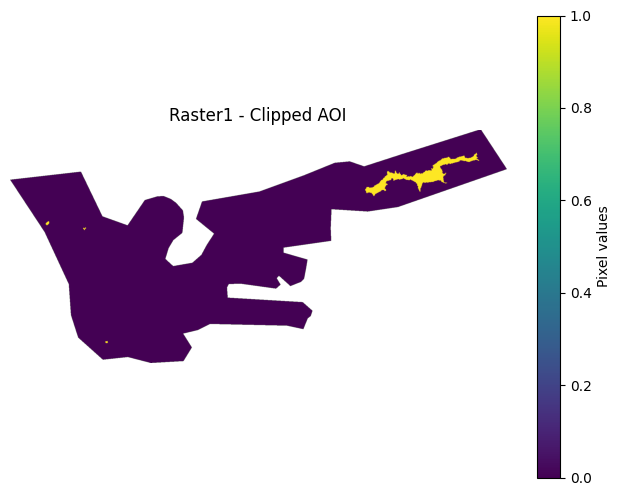

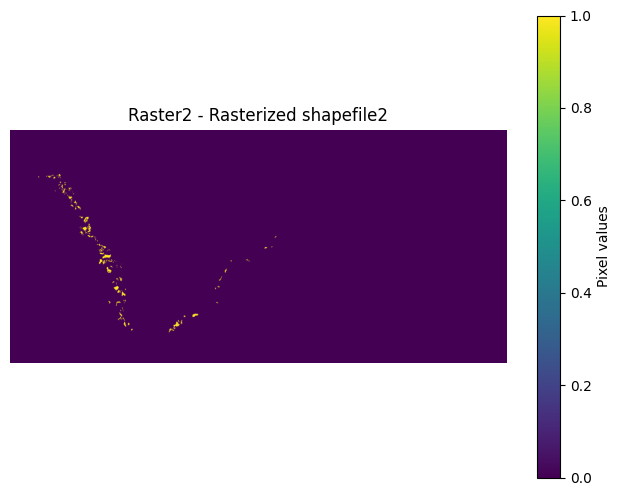

⚙️ Aligning and reprojecting exclusion mask to match reference raster...


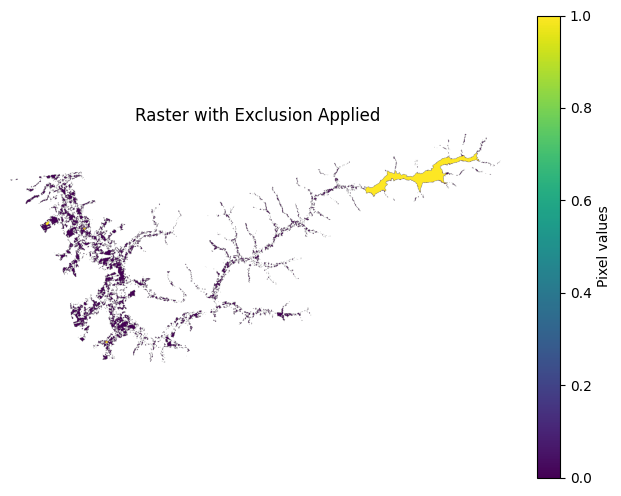

🧭 Excluding 604030 pixels from evaluation.

📊 Total pixels in clipped extent: 1814736
📊 Pixels masked (nodata): 1735655
📊 Pixels excluded: 604030
📊 Pixels evaluated (valid): 79081
✅ Accuracy  : 0.7858
✅ Precision : 0.0043
✅ Recall    : 0.0262
✅ F1-score  : 0.0074


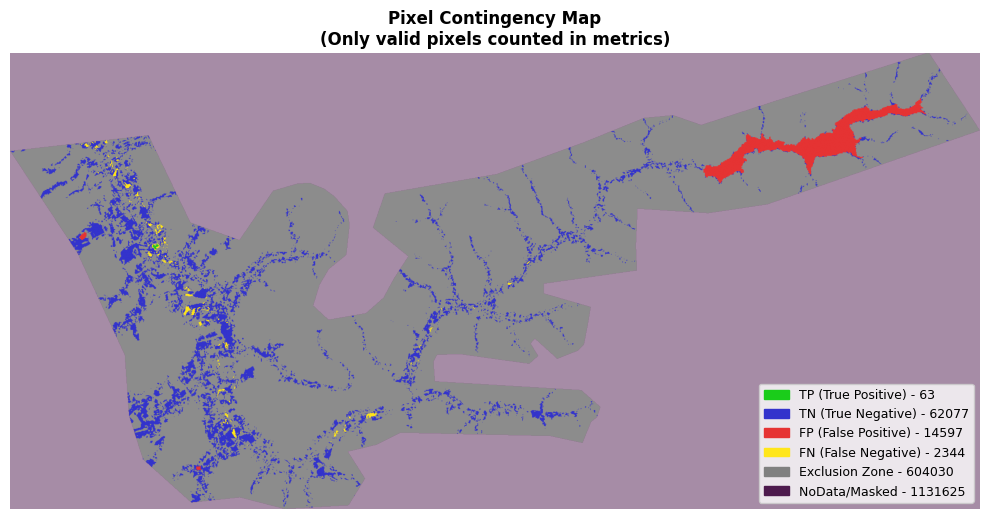

In [12]:
metrics = full_workflow(
    raster_path="/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__ensemble_water_extent.tif",   ### This is also reference for vector to raster conversion of EMSR flood polygons
    shapefile1_path="/content/EMSR789_AOI05_DEL_PRODUCT_areaOfInterestA_v1.shp",     ####### Area of Interest EMSR
    shapefile2_path="/content/EMSR789_AOI05_DEL_PRODUCT_observedEventA_v1.shp",      ######### Observerd Event EMSR
    exclusion_path="/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__exclusion_mask.tif",   # optional
    out_dir="/content/output"     ######## Where data needs to be stored
)



## Multi Flood Maps : Comparing 4 GFM products

In [14]:
## Multi
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.patches as mpatches
import pandas as pd


# =====================================================
# Multi-Raster Workflow
# =====================================================
def multi_raster_workflow(
    raster_paths_dict,  # Dictionary: {"name": "path"}
    shapefile1_path,    # AOI shapefile
    shapefile2_path,    # Reference shapefile
    exclusion_path=None,
    out_dir="./output"
):
    """
    Process multiple rasters and compare them all against the reference.

    Parameters:
    -----------
    raster_paths_dict : dict
        Dictionary with format {"map_name": "path/to/raster.tif"}
        Example: {"DLR": "path/dlr.tif", "LIST": "path/list.tif"}
    shapefile1_path : str
        Path to AOI shapefile for clipping
    shapefile2_path : str
        Path to reference shapefile (ground truth)
    exclusion_path : str, optional
        Path to exclusion mask raster
    out_dir : str
        Output directory for processed files

    Returns:
    --------
    dict : Dictionary containing metrics for each raster
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # Step 1: Process reference shapefile (only once)
    print("="*60)
    print("📋 STEP 1: Processing Reference Data")
    print("="*60)

    # We'll use the first raster as reference for alignment
    first_raster = list(raster_paths_dict.values())[0]
    first_name = list(raster_paths_dict.keys())[0]

    # Clip first raster to AOI (use as reference)
    print(f"\n🗺️  Using '{first_name}' as reference for alignment...")
    reference_clipped = Path(out_dir) / "reference_raster_clipped.tif"
    clip_raster_to_aoi(first_raster, shapefile1_path, reference_clipped, show=False)

    # Rasterize reference shapefile
    print("\n🎯 Rasterizing ground truth shapefile...")
    reference_truth = Path(out_dir) / "ground_truth_rasterized.tif"
    rasterize_vector_like(shapefile2_path, reference_clipped, reference_truth, show=False)

    # Process exclusion mask if provided
    exclusion_ready = None
    if exclusion_path:
        print("\n🚫 Processing exclusion mask...")
        exclusion_aligned = Path(out_dir) / "exclusion_aligned.tif"
        exclusion_ready = Path(out_dir) / "exclusion_clipped.tif"
        align_raster_to_reference(exclusion_path, reference_clipped, exclusion_aligned)
        clip_raster_to_aoi(exclusion_aligned, shapefile1_path, exclusion_ready, show=False)
        print("✅ Exclusion mask ready")

    # Step 2: Process each raster
    print("\n" + "="*60)
    print("📋 STEP 2: Processing Individual Rasters")
    print("="*60)

    all_metrics = {}
    processed_rasters = {}

    for name, raster_path in raster_paths_dict.items():
        print(f"\n{'='*60}")
        print(f"🗺️  Processing: {name}")
        print(f"{'='*60}")

        # Create subdirectory for this raster
        raster_out_dir = Path(out_dir) / name
        raster_out_dir.mkdir(exist_ok=True)

        # Clip raster to AOI
        clipped = raster_out_dir / f"{name}_clipped.tif"
        clip_raster_to_aoi(raster_path, shapefile1_path, clipped, show=False)

        # Apply exclusion mask if available
        if exclusion_ready:
            excluded = raster_out_dir / f"{name}_excluded.tif"
            apply_exclusion_layer(clipped, exclusion_ready, excluded, show=False)
            final_raster = excluded
        else:
            final_raster = clipped

        processed_rasters[name] = final_raster

        # Compare against ground truth
        print(f"\n📊 Evaluating {name} against ground truth...")
        metrics = compare_rasters_inside_aoi(
            final_raster,
            reference_truth,
            exclusion_path=exclusion_ready,
            show_plot=False  # We'll create a combined plot later
        )

        all_metrics[name] = metrics
        print(f"✅ {name} processing complete")

    # Step 3: Create comparison summary
    print("\n" + "="*60)
    print("📋 STEP 3: Creating Comparison Summary")
    print("="*60)

    create_comparison_summary(all_metrics, out_dir)

    # Step 4: Visualize all confusion maps
    print("\n📊 Creating visual comparison...")
    visualize_all_confusion_maps(
        processed_rasters,
        reference_truth,
        exclusion_ready,
        all_metrics,
        out_dir
    )

    return all_metrics


# =====================================================
# Create comparison summary table
# =====================================================
def create_comparison_summary(all_metrics, out_dir):
    """Create a summary table of all metrics"""
    summary_data = []
    for name, metrics in all_metrics.items():
        summary_data.append({
            "Map": name,
            "Accuracy": f"{metrics['accuracy']:.4f}",
            "Precision": f"{metrics['precision']:.4f}",
            "Recall": f"{metrics['recall']:.4f}",
            "F1-Score": f"{metrics['f1']:.4f}"
        })

    df = pd.DataFrame(summary_data)

    print("\n" + "="*60)
    print("📊 COMPARISON SUMMARY")
    print("="*60)
    print(df.to_string(index=False))

    # Save to CSV
    csv_path = Path(out_dir) / "metrics_comparison.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n💾 Summary saved to: {csv_path}")

    return df


# =====================================================
# Visualize all confusion maps in one figure
# =====================================================
def visualize_all_confusion_maps(processed_rasters, reference_truth, exclusion_ready, all_metrics, out_dir):
    """Create a grid of confusion maps for all rasters"""
    n_rasters = len(processed_rasters)
    n_cols = min(2, n_rasters)
    n_rows = (n_rasters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 8*n_rows))
    if n_rasters == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rasters > 2 else axes

    colors = {
        1: (0.1, 0.8, 0.1, 1.0),  # TP - green
        2: (0.2, 0.2, 0.8, 1.0),  # TN - blue
        3: (0.9, 0.2, 0.2, 1.0),  # FP - red
        4: (1.0, 0.9, 0.1, 1.0),  # FN - yellow
        5: (0.5, 0.5, 0.5, 0.9),  # EXCLUSION - gray
        6: (0.3, 0.1, 0.3, 0.5),  # NoData - dark purple
        255: (0, 0, 0, 0.0),      # Invalid - transparent
    }

    for idx, (name, raster_path) in enumerate(processed_rasters.items()):
        ax = axes[idx] if n_rasters > 1 else axes[0]

        # Build confusion map for this raster
        with rasterio.open(raster_path) as src_pred, rasterio.open(reference_truth) as src_ref:
            pred = src_pred.read(1, masked=True)
            ref = src_ref.read(1, masked=True)
            valid = ~pred.mask & ~ref.mask

            if exclusion_ready:
                with rasterio.open(exclusion_ready) as src_excl:
                    excl = src_excl.read(1, masked=False)
                    valid = valid & (excl != 1)
            else:
                excl = np.zeros_like(ref, dtype=np.uint8)

            pred_bin = (np.where(pred.mask, 0, pred.data) > 0).astype(np.uint8)
            ref_bin = (np.where(ref.mask, 0, ref.data) > 0).astype(np.uint8)

            conf_map = np.full_like(ref_bin, 255, dtype=np.uint8)

            TP = (pred_bin == 1) & (ref_bin == 1) & valid
            TN = (pred_bin == 0) & (ref_bin == 0) & valid
            FP = (pred_bin == 1) & (ref_bin == 0) & valid
            FN = (pred_bin == 0) & (ref_bin == 1) & valid

            conf_map[TP] = 1
            conf_map[TN] = 2
            conf_map[FP] = 3
            conf_map[FN] = 4
            conf_map[excl == 1] = 5
            conf_map[(pred.mask | ref.mask) & (excl != 1)] = 6

        # Create RGBA image
        rgba = np.zeros((*conf_map.shape, 4))
        for k, v in colors.items():
            rgba[conf_map == k] = v

        ax.imshow(rgba)
        metrics = all_metrics[name]
        title = f"{name}\nAcc: {metrics['accuracy']:.3f} | F1: {metrics['f1']:.3f}"
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis("off")

    # Hide extra subplots if odd number
    for idx in range(n_rasters, len(axes)):
        axes[idx].axis('off')

    # Add legend to the last subplot
    legend_patches = [
        mpatches.Patch(color=colors[1][:3], label="TP (True Positive)"),
        mpatches.Patch(color=colors[2][:3], label="TN (True Negative)"),
        mpatches.Patch(color=colors[3][:3], label="FP (False Positive)"),
        mpatches.Patch(color=colors[4][:3], label="FN (False Negative)"),
        mpatches.Patch(color=colors[5][:3], label="Exclusion Zone"),
        mpatches.Patch(color=colors[6][:3], label="NoData/Masked"),
    ]

    fig.legend(handles=legend_patches, loc='lower center', ncol=6,
               bbox_to_anchor=(0.5, -0.02), fontsize=10)

    plt.tight_layout()

    # Save figure
    fig_path = Path(out_dir) / "confusion_maps_comparison.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"💾 Confusion maps saved to: {fig_path}")

    plt.show()


# =====================================================
# Keep original utility functions (from previous code)
# =====================================================
def show_raster(raster_path, title="Raster Preview", cmap='viridis'):
    with rasterio.open(raster_path) as src:
        data = src.read(1, masked=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap=cmap)
    plt.title(title)
    plt.colorbar(label="Pixel values")
    plt.axis("off")
    plt.show()


def align_raster_to_reference(input_raster, reference_raster, out_path):
    with rasterio.open(input_raster) as src, rasterio.open(reference_raster) as ref:
        if src.crs != ref.crs or src.transform != ref.transform or src.shape != ref.shape:
            print("⚙️ Aligning and reprojecting exclusion mask to match reference raster...")
            transform, width, height = calculate_default_transform(
                src.crs, ref.crs, ref.width, ref.height, *ref.bounds
            )

            kwargs = ref.meta.copy()
            kwargs.update({
                'transform': ref.transform,
                'width': ref.width,
                'height': ref.height,
                'crs': ref.crs
            })

            data = np.zeros((ref.count, ref.height, ref.width), dtype=src.read(1).dtype)
            reproject(
                source=rasterio.band(src, 1),
                destination=data[0],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                resampling=Resampling.nearest
            )

            with rasterio.open(out_path, 'w', **kwargs) as dst:
                dst.write(data)
        else:
            print("✅ Raster already aligned with reference.")
            data = src.read(1)
            kwargs = src.meta
            with rasterio.open(out_path, 'w', **kwargs) as dst:
                dst.write(data, 1)

    return out_path


def clip_raster_to_aoi(raster_path, shapefile_path, out_path, show=True):
    gdf = gpd.read_file(shapefile_path)
    with rasterio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(out_path, "w", **out_meta) as dst:
            dst.write(out_image)

    if show:
        show_raster(out_path, "Raster - Clipped AOI")
    return out_path


def rasterize_vector_like(vector_path, reference_raster, out_path, burn_value=1, show=True):
    gdf = gpd.read_file(vector_path)
    with rasterio.open(reference_raster) as ref:
        transform, out_shape, crs, dtype, nodata = ref.transform, (ref.height, ref.width), ref.crs, ref.dtypes[0], ref.nodata
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)
    shapes = ((geom, burn_value) for geom in gdf.geometry)
    raster = rasterize(shapes, out_shape=out_shape, transform=transform, fill=0, dtype=dtype)
    meta = {"driver": "GTiff", "height": raster.shape[0], "width": raster.shape[1],
            "count": 1, "dtype": dtype, "crs": crs, "transform": transform, "nodata": nodata}
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(raster, 1)
    if show:
        show_raster(out_path, "Rasterized Vector")
    return out_path


def apply_exclusion_layer(target_raster, exclusion_raster, out_path, show=True):
    with rasterio.open(target_raster) as target, rasterio.open(exclusion_raster) as excl:
        target_data = target.read(1)
        excl_data = excl.read(1)
        target_data[excl_data == 1] = target.nodata if target.nodata is not None else 0
        meta = target.meta
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(target_data, 1)
    if show:
        show_raster(out_path, "Raster with Exclusion Applied")
    return out_path


def compare_rasters_inside_aoi(pred_path, ref_path, exclusion_path=None, show_plot=True):
    with rasterio.open(pred_path) as src_pred, rasterio.open(ref_path) as src_ref:
        pred = src_pred.read(1, masked=True)
        ref = src_ref.read(1, masked=True)
        valid = ~pred.mask & ~ref.mask

        if exclusion_path:
            with rasterio.open(exclusion_path) as src_excl:
                excl = src_excl.read(1, masked=False)
                valid = valid & (excl != 1)
                print(f"🧭 Excluding {np.sum(excl==1)} pixels from evaluation.")
        else:
            excl = np.zeros_like(ref, dtype=np.uint8)

        pred_bin = (np.where(pred.mask, 0, pred.data) > 0).astype(np.uint8)
        ref_bin = (np.where(ref.mask, 0, ref.data) > 0).astype(np.uint8)

        pred_flat, ref_flat = pred_bin[valid], ref_bin[valid]

        acc = accuracy_score(ref_flat, pred_flat)
        prec = precision_score(ref_flat, pred_flat, zero_division=0)
        rec = recall_score(ref_flat, pred_flat, zero_division=0)
        f1 = f1_score(ref_flat, pred_flat, zero_division=0)

        print(f"\n📊 Total pixels in clipped extent: {pred_bin.size}")
        print(f"📊 Pixels masked (nodata): {np.sum(pred.mask | ref.mask)}")
        print(f"📊 Pixels excluded: {np.sum(excl==1) if exclusion_path else 0}")
        print(f"📊 Pixels evaluated (valid): {pred_flat.size}")
        print(f"✅ Accuracy  : {acc:.4f}")
        print(f"✅ Precision : {prec:.4f}")
        print(f"✅ Recall    : {rec:.4f}")
        print(f"✅ F1-score  : {f1:.4f}")

        conf_map = np.full_like(ref_bin, 255, dtype=np.uint8)

        TP = (pred_bin == 1) & (ref_bin == 1) & valid
        TN = (pred_bin == 0) & (ref_bin == 0) & valid
        FP = (pred_bin == 1) & (ref_bin == 0) & valid
        FN = (pred_bin == 0) & (ref_bin == 1) & valid

        conf_map[TP] = 1
        conf_map[TN] = 2
        conf_map[FP] = 3
        conf_map[FN] = 4
        conf_map[excl == 1] = 5
        conf_map[(pred.mask | ref.mask) & (excl != 1)] = 6

    if show_plot:
        colors = {
            1: (0.1, 0.8, 0.1, 1.0),
            2: (0.2, 0.2, 0.8, 1.0),
            3: (0.9, 0.2, 0.2, 1.0),
            4: (1.0, 0.9, 0.1, 1.0),
            5: (0.5, 0.5, 0.5, 0.9),
            6: (0.3, 0.1, 0.3, 0.5),
            255: (0, 0, 0, 0.0),
        }

        rgba = np.zeros((*conf_map.shape, 4))
        for k, v in colors.items():
            rgba[conf_map == k] = v

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(rgba)
        ax.set_title("Pixel Contingency Map", fontsize=12, fontweight='bold')
        ax.axis("off")

        legend_patches = [
            mpatches.Patch(color=colors[1][:3], label=f"TP - {np.sum(TP)}"),
            mpatches.Patch(color=colors[2][:3], label=f"TN - {np.sum(TN)}"),
            mpatches.Patch(color=colors[3][:3], label=f"FP - {np.sum(FP)}"),
            mpatches.Patch(color=colors[4][:3], label=f"FN - {np.sum(FN)}"),
            mpatches.Patch(color=colors[5][:3], label=f"Exclusion - {np.sum(conf_map==5)}"),
            mpatches.Patch(color=colors[6][:3], label=f"NoData - {np.sum(conf_map==6)}"),
        ]
        ax.legend(handles=legend_patches, loc="lower right", fontsize=9)
        plt.tight_layout()
        plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_map": conf_map,
    }

📋 STEP 1: Processing Reference Data

🗺️  Using 'DLR' as reference for alignment...

🎯 Rasterizing ground truth shapefile...

🚫 Processing exclusion mask...
⚙️ Aligning and reprojecting exclusion mask to match reference raster...
✅ Exclusion mask ready

📋 STEP 2: Processing Individual Rasters

🗺️  Processing: DLR

📊 Evaluating DLR against ground truth...
🧭 Excluding 604030 pixels from evaluation.

📊 Total pixels in clipped extent: 1814736
📊 Pixels masked (nodata): 1735655
📊 Pixels excluded: 604030
📊 Pixels evaluated (valid): 79081
✅ Accuracy  : 0.9693
✅ Precision : 0.0000
✅ Recall    : 0.0000
✅ F1-score  : 0.0000
✅ DLR processing complete

🗺️  Processing: LIST

📊 Evaluating LIST against ground truth...
🧭 Excluding 604030 pixels from evaluation.

📊 Total pixels in clipped extent: 1814736
📊 Pixels masked (nodata): 1735655
📊 Pixels excluded: 604030
📊 Pixels evaluated (valid): 79081
✅ Accuracy  : 0.9662
✅ Precision : 0.3485
✅ Recall    : 0.1271
✅ F1-score  : 0.1863
✅ LIST processing complet

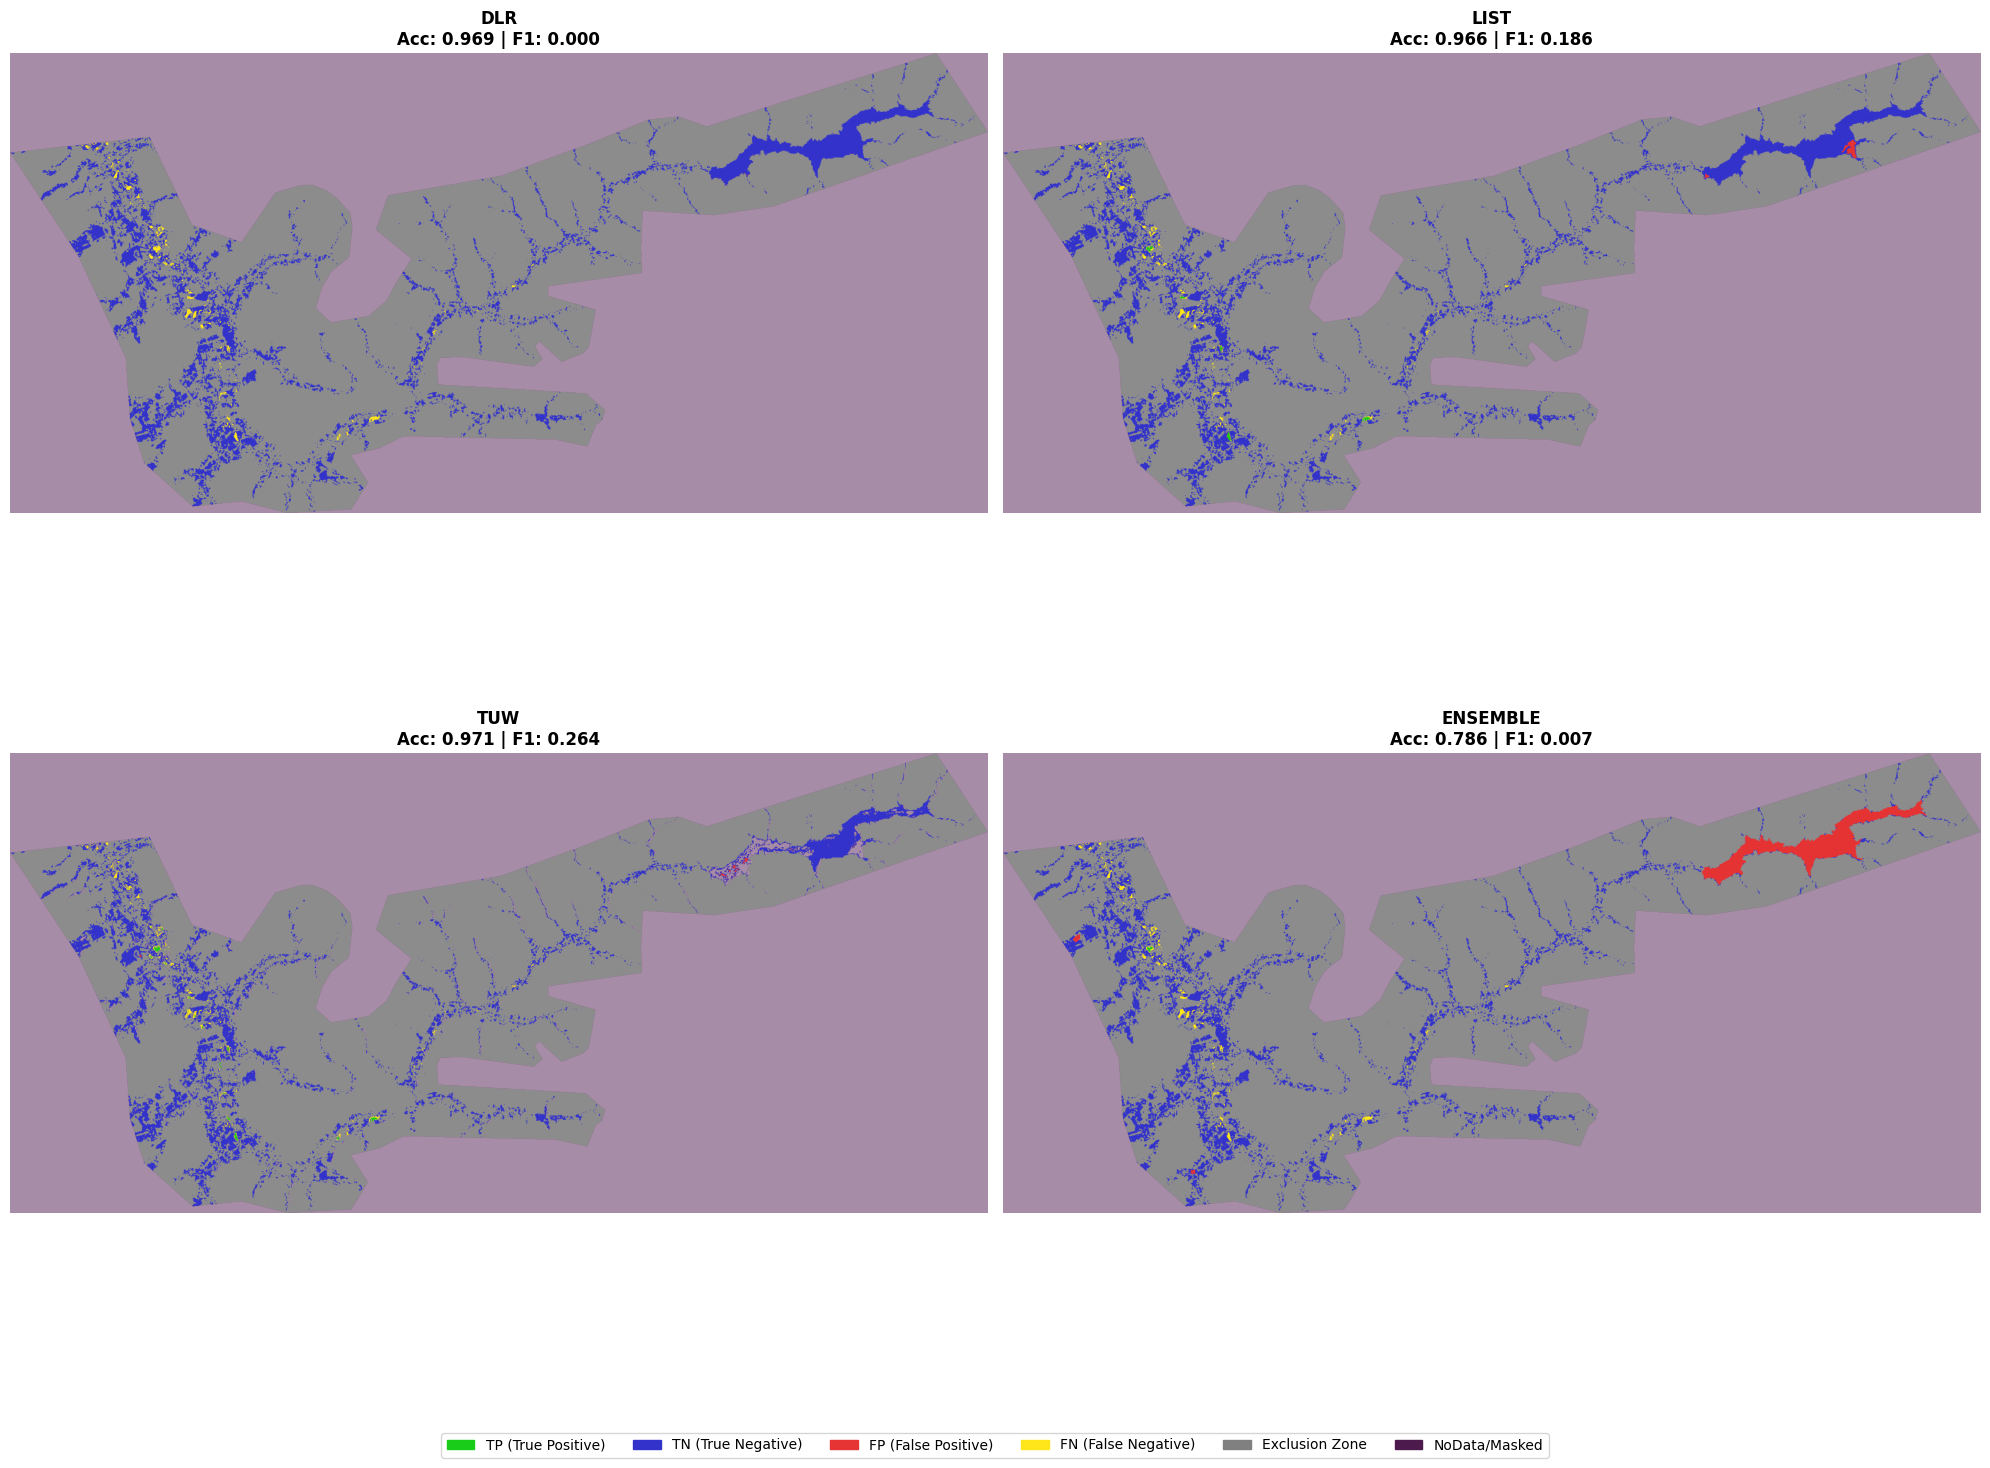

In [15]:
# Define all your rasters in a dictionary
raster_maps = {
    "DLR": "/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__dlr_flood_extent.tif",
    "LIST": "/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__list_flood_extent.tif",
    "TUW": "/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__tuw_flood_extent.tif",
    "ENSEMBLE": "/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__ensemble_water_extent.tif"
}

# Run the multi-raster workflow
all_metrics = multi_raster_workflow(
    raster_paths_dict=raster_maps,
    shapefile1_path="/content/EMSR789_AOI05_DEL_PRODUCT_areaOfInterestA_v1.shp",
    shapefile2_path="/content/EMSR789_AOI05_DEL_PRODUCT_observedEventA_v1.shp",
    exclusion_path="/content/ENSEMBLE_FLOOD_20250308T110125_VV_SA020M_E048N069T3__exclusion_mask.tif",   # optional
    out_dir="/content/output"
)
